## Part 1: Building a Decision Tree

Decision Trees can be applied to both Regression and Classification problems and are really good at handling complex non-linear relationships. In this demo, we will utilize the California Housing dataset once again. This time, we'll keep all of the original predictors to train a Decision Tree model for both a Regression problem (predicting Median House Value) and a Classification problem (predicting Value Group). Finally, we'll compare the Decision Tree to Linear and Logistic Regression Models trained on the same data.



In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from sklearn.datasets import fetch_california_housing
import pandas as pd

california_housing = fetch_california_housing(as_frame=True)
housing_df = california_housing.frame

housing_df['ValueGroup'] = 0
housing_df.loc[(housing_df['MedHouseVal'] >=2),['ValueGroup']] = 1

In [ ]:
X = housing_df.drop(['ValueGroup','MedHouseVal'], axis = 1)
y_reg = housing_df['MedHouseVal']
y_clf = housing_df['ValueGroup']

In [ ]:
from sklearn.model_selection import train_test_split
#Apply the Train/Test Split protocol
X_train, X_test, y_reg_train, y_reg_test, y_clf_train, y_clf_test = train_test_split(X, y_reg, y_clf, test_size=0.2, random_state=42)

### Feature Scaling

Observing the statistics for all of the features in the dataset, you'll notice that some features are on vastly different scales. As mentioned before, this might cause the model to be biased towards some features over others.

In [ ]:
housing_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal,ValueGroup
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,3.870671,28.639486,5.429000,1.096675,1425.476744,3.070655,35.631861,-119.569704,2.068558,0.424176
std,1.899822,12.585558,2.474173,0.473911,1132.462122,10.386050,2.135952,2.003532,1.153956,0.494229
min,0.499900,1.000000,0.846154,0.333333,3.000000,0.692308,32.540000,-124.350000,0.149990,0.000000
25%,2.563400,18.000000,4.440716,1.006079,787.000000,2.429741,33.930000,-121.800000,1.196000,0.000000
50%,3.534800,29.000000,5.229129,1.048780,1166.000000,2.818116,34.260000,-118.490000,1.797000,0.000000
75%,4.743250,37.000000,6.052381,1.099526,1725.000000,3.282261,37.710000,-118.010000,2.647250,1.000000
max,15.000100,52.000000,141.909091,34.066667,35682.000000,1243.333333,41.950000,-114.310000,5.000010,1.000000


To prevent this we will apply feature scaling to all features to standardize them in a fixed range. Here we will use the $\texttt{StandardScaler}$ in $\texttt{sklearn}$.

This method of scaling calculates the mean and standard deviation of the data, then subtracts the mean value from each entry and divides the result by the standard deviation. Note that we only scale the predictors not the targets.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

scaled_X_train = scaler.transform(X_train)
scaled_X_test = scaler.transform(X_test)

In [ ]:
scaled_X_train

array([[-0.326196  ,  0.34849025, -0.17491646, ...,  0.05137609,
        -1.3728112 ,  1.27258656],
       [-0.03584338,  1.61811813, -0.40283542, ..., -0.11736222,
        -0.87669601,  0.70916212],
       [ 0.14470145, -1.95271028,  0.08821601, ..., -0.03227969,
        -0.46014647, -0.44760309],
       ...,
       [-0.49697313,  0.58654547, -0.60675918, ...,  0.02030568,
        -0.75500738,  0.59946887],
       [ 0.96545045, -1.07984112,  0.40217517, ...,  0.00707608,
         0.90651045, -1.18553953],
       [-0.68544764,  1.85617335, -0.85144571, ..., -0.08535429,
         0.99543676, -1.41489815]])

Other feature scaling methods include $\textbf{Absolute Maximum Scaling}$, $\textbf{Min-Max Scaling}$, $\textbf{Normalization}$, etc.

### Decision Tree

Let's first train a Decision Tree Regressor for Regression and evaluate using Mean Absolute Error. Recall again that the formula for MAE is:
$$MAE = \frac{1}{n} \times \sum_{i=1}^{n}(|(y_{pred})_{i}-(y_{true})_{i}|)$$

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

regressor = DecisionTreeRegressor(random_state=0)
regressor.fit(scaled_X_train, y_reg_train)

DecisionTreeRegressor(random_state=0)

In [ ]:
y_pred_train_reg = regressor.predict(scaled_X_train)
mae_train = mean_absolute_error(y_reg_train, y_pred_train_reg)
mae_train

4.2117472300460155e-17

This near-zero MAE indicates perfect performance on the Training Set. Should we be celebrating? Unfortunately no, this likely indicates that our model is overfitting. Let's verify on our test set.

In [ ]:
y_pred_test_reg = regressor.predict(scaled_X_test)
mae_test = mean_absolute_error(y_reg_test, y_pred_test_reg)
mae_test

0.45390664001937986

As expected, on the test set we are still off by nearly half a hundred thousand dollars. We want our model to be generalizable to unseen data, hence an overfitting model is bad news. Let's have a look at how our trained decision tree is structured to get an idea of why Decision Trees overfit so easily.

In [ ]:
print("Depth:",regressor.get_depth())
print("Leaves:",regressor.get_n_leaves())
print("X_train Samples:", len(X_train))

Depth: 34
Leaves: 15866
X_train Samples: 16512


The tree has grown too much, allowing it to create a leaf node for almost every individual sample in the training dataset. An easy way to prevent this is to limit the depth of the decision trees. For this demo let's set the maximum depth of the tree to be 7 for both regression and classification. We will discuss more about pruning trees in the next module.

#### Decision Tree vs. Linear Regression

Using the depth limit, let's train and compare the Decision Tree with a Linear Regression Model.

In [ ]:
#Train and evaluate Decision Tree Regressor
dt_reg = DecisionTreeRegressor(max_depth=7, random_state=0)
dt_reg.fit(scaled_X_train, y_reg_train)

y_pred_dt_reg= dt_reg.predict(scaled_X_train)
mae_train_dt = mean_absolute_error(y_reg_train, y_pred_dt_reg)

y_pred_dt_reg= dt_reg.predict(scaled_X_test)
mae_test_dt = mean_absolute_error(y_reg_test, y_pred_dt_reg)

In [ ]:
from sklearn.linear_model import LinearRegression

#Train and evaluate Linear Regression Model
lin = LinearRegression()
lin.fit(scaled_X_train, y_reg_train)

y_pred_lin_reg= lin.predict(scaled_X_train)
mae_train_lin = mean_absolute_error(y_reg_train, y_pred_lin_reg)

y_pred_lin_reg= lin.predict(scaled_X_test)
mae_test_lin = mean_absolute_error(y_reg_test, y_pred_lin_reg)

In [ ]:
print("Decision Tree")
print("Train MAE:", mae_train_dt)
print("Test MAE:", mae_test_dt)
print()
print("Linear Regression")
print("Train MAE:", mae_train_lin)
print("Test MAE:", mae_train_lin)

Decision Tree
Train MAE: 0.43908971029005955
Test MAE: 0.47316139734802376

Linear Regression
Train MAE: 0.5286283596581932
Test MAE: 0.5286283596581932


The Decision Tree outperforms the Linear Regression Model due to it's advantage in capturing non-linear relationships. However, it is still slightly overfitting to the training set, implying that additional pruning could be considered.

#### Decision Tree vs. Logistic Regression

Now let's do a similar comparison for the classification problem. We will use the $\texttt{DecisionTreeClassifier}$ and evaluate using the accuracy score.

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

#Train and evaluate Decision Tree Classifier
dt_clf = DecisionTreeClassifier(max_depth=7, random_state=0)
dt_clf.fit(scaled_X_train, y_clf_train)

y_pred_dt_clf= dt_clf.predict(scaled_X_train)
acc_train_dt = accuracy_score(y_clf_train, y_pred_dt_clf)

y_pred_dt_clf= dt_clf.predict(scaled_X_test)
acc_test_dt = accuracy_score(y_clf_test, y_pred_dt_clf)

In [ ]:
from sklearn.linear_model import LogisticRegression

#Train and evaluate Logistic Regression Model
log = LogisticRegression()
log.fit(scaled_X_train, y_clf_train)

y_pred_log_clf= log.predict(scaled_X_train)
acc_train_log = accuracy_score(y_clf_train, y_pred_log_clf)

y_pred_log_clf= log.predict(scaled_X_test)
acc_test_log = accuracy_score(y_clf_test, y_pred_log_clf)

In [ ]:
print("Decision Tree")
print("Train Accuracy:", acc_train_dt)
print("Test Accuracy:", acc_test_dt)
print()
print("Logistic Regression")
print("Train Accuracy:", acc_train_log)
print("Test Accuracy:", acc_train_log)

Decision Tree
Train Accuracy: 0.8602228682170543
Test Accuracy: 0.8355135658914729

Logistic Regression
Train Accuracy: 0.8304263565891473
Test Accuracy: 0.8304263565891473


Similar to the regression problem, the Decision Tree outperforms the Logistic Regression Model. Though it should be noted that, with the addition of more features, the performance of the Logistic Regression model also improves in comparison to the previous demo.

## Part 2: Interpreting a Decision Tree

Decision Trees are useful for interpreting decisions and measuring feature importance. Using the tree Decision Tree Classifier as an example, let's first visualize the structure of the learned tree using $\texttt{plot_tree}$.

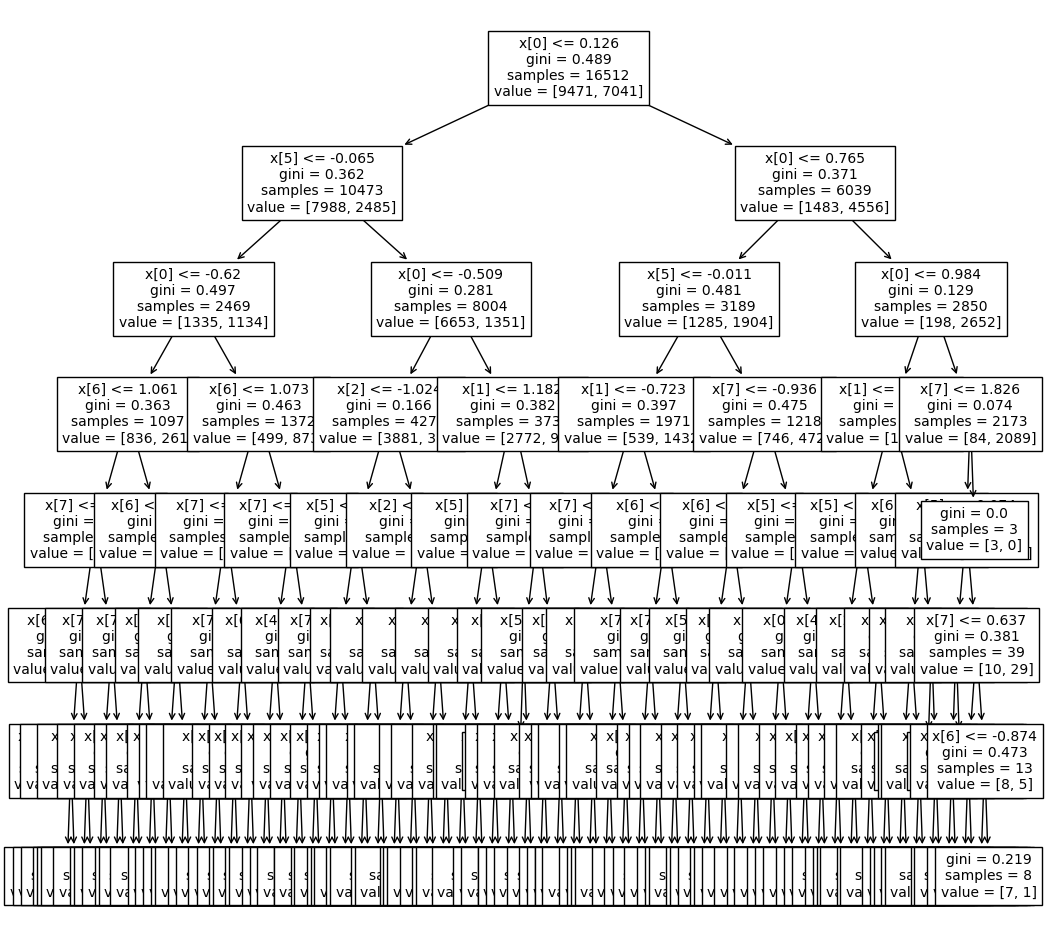

In [ ]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

# plot tree
plt.figure(figsize=(12,12))  # set plot size (denoted in inches)
plot_tree(dt_clf, fontsize=10)
plt.show()

Even though we've limited the depth of the tree, it still looks pretty large. Each square corresponds to a node in the tree representing a decision rule used to split data. The higher the node, the more effective the decision, the more important the corresponding feature might be.

From this structure, we can have a better idea of what decisions were made during the prediction process of the Decision Tree. This, in turn, can be referenced during human decision-making.

We can also directly quantify the importance of the features as shown below.

In [ ]:
#construct dataframe
feature_importance = pd.DataFrame({'Features':X.columns.tolist(),"Importances":dt_clf.feature_importances_})

#sort in order of decreasing importance
feature_importance = feature_importance.sort_values(by="Importances",ascending=False)

feature_importance

,Features,Importances
0,MedInc,0.580700
5,AveOccup,0.140587
7,Longitude,0.112362
6,Latitude,0.096358
1,HouseAge,0.045772
2,AveRooms,0.013879
3,AveBedrms,0.006174
4,Population,0.004169


From this, we can therefore conclude that ‘MedInc’, followed by ‘AveOccup’ are the two most relevant features for determining which Value Group a house lies in.